In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/mnt/Data/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/")

In [3]:
import numpy as np
import matplotlib.pyplot as pl
import spectrum as sp
import pickle as pkl
import scipy.signal as scsig
import pywt
import colormaps as mycmps
import signale.tools as tools
import os
import itertools
import pandas as pd

/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Data

In [4]:
animalPath = '/home/chenani/dataWork/ali/Gerbils/gerbil5/'
cscPath = '/home/chenani/dataWork/ali/gerbil5/2011-08-07/sleep3/'

In [4]:
#ephys = pkl.load(open(animalPath+'sleep1.ephys','rb'))
#ch0.whitenARMA()
#pkl.dump(ch0,open(animalPath+'lfp','wb'),pkl.HIGHEST_PROTOCOL)
#ephys.LFPs.plot()

In [5]:
#ch = ephys.LFPs[3]
#ch.whitenARMA()
#ch.ripple_recorder()

In [6]:
#pkl.dump(ch,open(animalPath+'csc4.lfp','wb'),pkl.HIGHEST_PROTOCOL)

In [5]:
lfpPaths = []
for lfp in tools.locate('*.lfp',animalPath):
    lfpPaths.append(os.path.join(lfp[0],lfp[1]))
lfpPaths = sorted(lfpPaths)
for path in lfpPaths:
    print path

/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep1/CSC1.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep1/CSC2.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep1/CSC3.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep1/CSC4.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep2/CSC1.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep2/CSC2.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep2/CSC3.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep2/CSC4.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep3/CSC1.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep3/CSC2.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep3/CSC3.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-04/sleep3/CSC4.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-05/sleep1/CSC1.lfp
/home/chenani/dataWork/ali/Gerbils/gerbil5/2011-08-05/sleep1/CSC2.lfp
/home/chenani/dataWo

# Wavelet Analysis Class

In [6]:
-


# Low pass Filter

In [7]:
lfpSample = pkl.load(open(lfpPaths[10],'rb'))

In [8]:
sample_rate = 2000.0

In [9]:
#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = scsig.kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 5.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = scsig.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

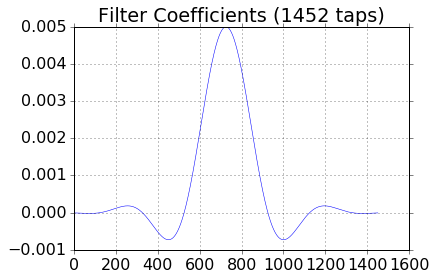

In [10]:
#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------
pl.figure(1)
pl.plot(taps, 'b-', linewidth=0.52)
pl.title('Filter Coefficients (%d taps)' % N)
pl.grid(True)

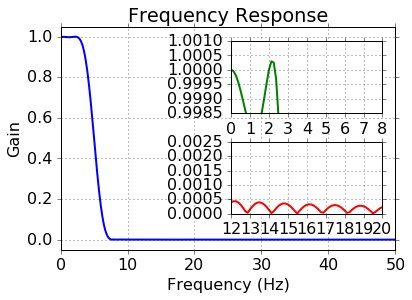

In [11]:
#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------
pl.figure(2)
pl.clf()
w, h = scsig.freqz(taps, worN=8000)
pl.plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
pl.xlabel('Frequency (Hz)')
pl.ylabel('Gain')
pl.title('Frequency Response')
pl.ylim(-0.05, 1.05)
pl.xlim(0,50)
pl.grid(True)

# Upper inset plot.
ax1 = pl.axes([0.52, 0.6, .35, .25])
pl.plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2,c='g')
pl.xlim(0,8.0)
pl.ylim(0.9985, 1.001)
pl.grid(True)

# Lower inset plot
ax2 = pl.axes([0.52, 0.25, .35, .25])
pl.plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2,c='r')
pl.xlim(12.0, 20.0)
pl.ylim(0.0, 0.0025)
pl.grid(True)

# Low frequency peaks

In [40]:
# Use lfilter to filter x with the FIR filter.
lfpSample.signal_white[0] = lfpSample.signal_white[1:3].mean()
lp_x = scsig.filtfilt(taps, 1.0,lfpSample.signal )
lp_w = scsig.filtfilt(taps, 1.0, lfpSample.signal_white)
rec_lp_x = np.fabs(lp_x)
rec_lp_w = np.fabs(lp_w)

In [41]:
lpPix = scsig.argrelextrema(rec_lp_w, np.greater)[0]
astrix = np.ones(lpPix.size)*rec_lp_w.max()

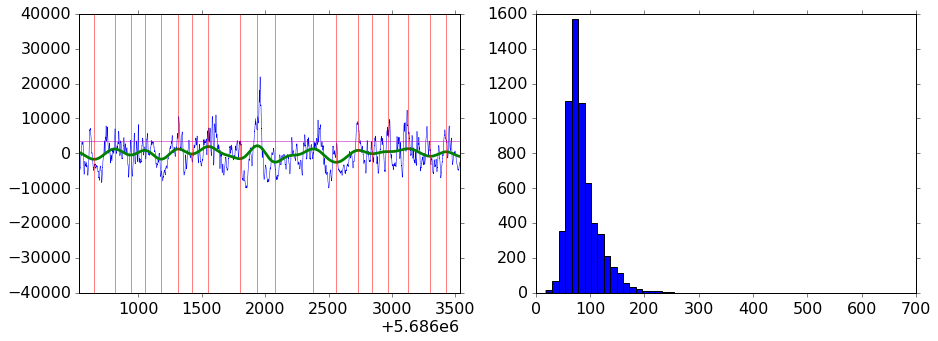

In [59]:
f,ax = pl.subplots(1,2,figsize=[15,5])
ax[0].plot(lfpSample.timeAxis[:],lfpSample.signal[:],lw=0.5)
ax[0].plot(lfpSample.timeAxis[:],90*lp_w[:],lw=2.75)
for item in lpPix:
    ax[0].axvline(lfpSample.timeAxis[item],lw=0.5,c='r')
ax[0].axhline(90*(lp_w.mean()+3*lp_w.std()),lw=0.5,c='m')
t1 = lfpSample.timeAxis[0] + lfpSample.duration()/2
ax[0].set_xlim(t1,t1+3000)
ax[1].hist(np.diff(0.5*lfpSample.timeAxis[lpPix]),50);

In [65]:
lpThresh = rec_lp_w.mean()+3.8*rec_lp_w.std()
print lpThresh
candidateIdx = np.array([peak for peak in lpPix if rec_lp_w[peak]>lpThresh])
candidateIdx.size

45.7384019128


18

In [61]:
sigZ = (lfpSample.signal - lfpSample.signal.mean())/lfpSample.signal.std()

NameError: name 'candidateIdx' is not defined

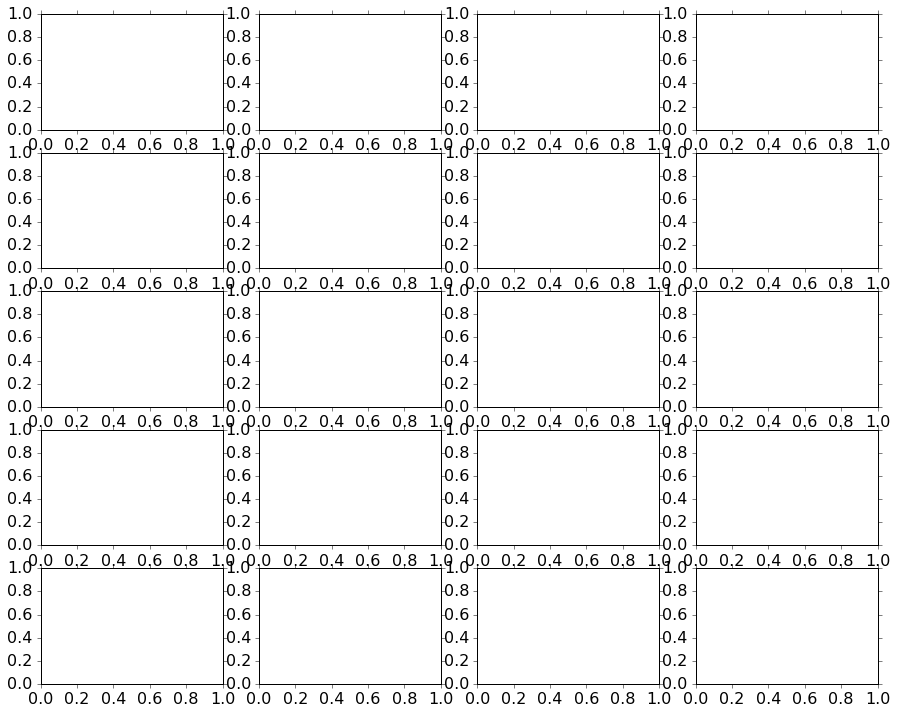

In [12]:
f,ax = pl.subplots(5,4,figsize=[15,12])
-

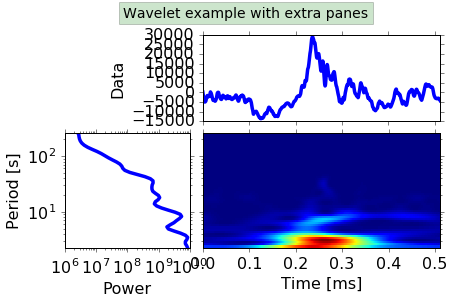

In [68]:
if __name__=="__main__":
    import numpy as np
    import pylab as pl

    wavelet=Morlet
    maxscale=4
    notes=8
    scaling="log" #or "linear"
    #scaling="linear"
    plotpower2d=True

    # set up some data
    Ns=1024
    #limits of analysis
    Nlo=0 
    Nhi=Ns
    cidx = 1
    signal_slice = lfpSample.signal[candidateIdx[cidx]-512:candidateIdx[cidx]+512]
    # Wavelet transform the data
    cw=wavelet(signal_slice,largestscale=maxscale,notes=notes,scaling=scaling)
    scales=cw.getscales()     
    cwt=cw.getdata()
    # power spectrum
    pwr=cw.getpower()
    scalespec=np.sum(pwr,axis=1)/scales # calculate scale spectrum
    # scales
    y=cw.fourierwl*scales
    x=np.arange(Nlo*1.0,Nhi*0.0005,0.0005)
    
    fig=pl.figure(1)

    # 2-d coefficient plot
    ax=pl.axes([0.4,0.1,0.55,0.4])
    pl.xlabel('Time [ms]')
    plotcwt=np.clip(np.fabs(cwt.real), 0., 1000.)
    if plotpower2d: plotcwt=pwr
    im=pl.pcolormesh(x,y[::-1],plotcwt,cmap=pl.cm.jet)
    ax.set_xlim(x[0],x[-1])#,y[-1],y[0]],aspect='auto')
    #colorbar()
    if scaling=="log": ax.set_yscale('log')
    pl.ylim(y[0],y[-1])
    ax.xaxis.set_ticks(np.arange(Nlo*1.0,(Nhi+1)*0.0005,0.1))
    ax.yaxis.set_ticklabels(["",""])
    theposition=pl.gca().get_position()

    # data plot
    ax2=pl.axes([0.4,0.54,0.55,0.3])
    pl.ylabel('Data')
    pos=ax.get_position()
    pl.plot(x,signal_slice,'b-')
    pl.xlim(Nlo*1.0,Nhi*0.0005)
    ax2.xaxis.set_ticklabels(["",""])
    pl.text(0.5,0.9,"Wavelet example with extra panes",
         fontsize=14,bbox=dict(facecolor='green',alpha=0.2),
         transform = fig.transFigure,horizontalalignment='center')

    # projected power spectrum
    ax3=pl.axes([0.08,0.1,0.29,0.4])
    pl.xlabel('Power')
    pl.ylabel('Period [s]')
    vara=1.0
    f = 1
    if scaling=="log":
        pl.loglog(scalespec/vara+0.01,y[::-1],'b-')
    else:
        pl.semilogx(scalespec/vara+0.01,y[::-1],'b-')
    pl.ylim(y[0],y[-1])
    #pl.xlim(6e4,1)
    
    pl.show()

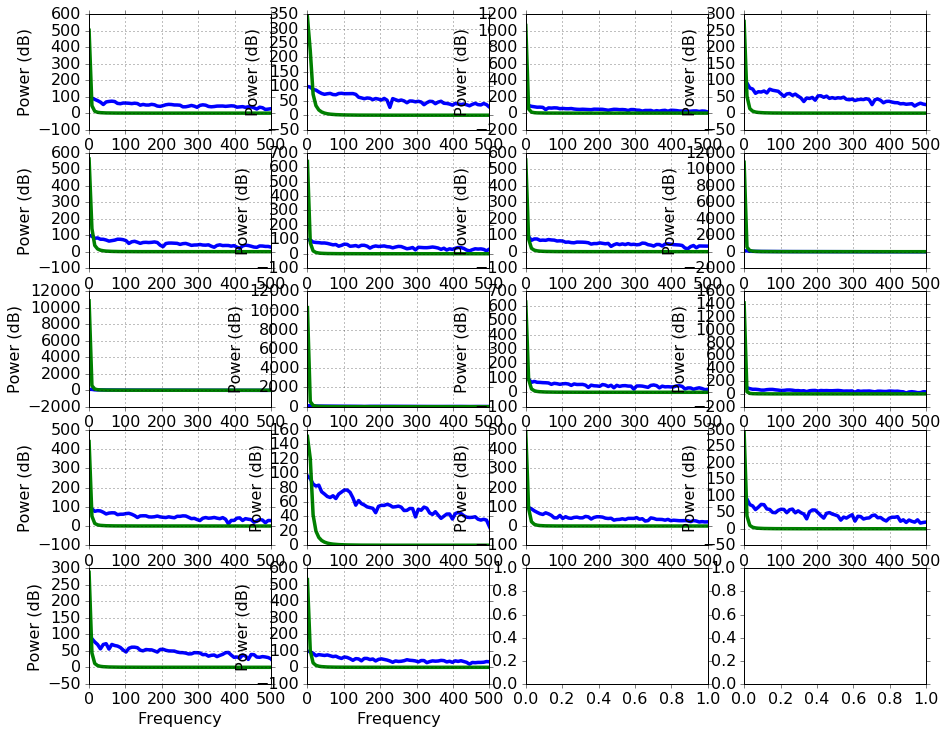

In [72]:
f,ax = pl.subplots(5,4,figsize=[15,12])
Ns=2000
for iii,item in enumerate(candidateIdx):
    sampleIdx = np.arange(item-128,item+128)
    p = sp.Periodogram(lfpSample.signal[sampleIdx],Ns)
    p()
    p.plot(ax=ax[iii/4,np.mod(iii,4)])
    p = sp.pyule(lfpSample.signal[sampleIdx],4)
    p()
    freqz = np.array(p.frequencies())*Ns
    ax[iii/4,np.mod(iii,4)].plot(freqz,p.psd*2e-8)
    ax[iii/4,np.mod(iii,4)].set_xlim(0,500)

# Traditional Method

In [89]:
###Selecting some of biggest detected ripples
rippPtimes = lfpSample.ripples[:,3]
rippPvalues = lfpSample.ripples[:,2]
idxSorted = rippPvalues.argsort()
candidateTimes = rippPtimes[idxSorted]

In [90]:
peakRippIdx = np.array([np.where(lfpSample.timeAxis==peakT)[0][0] for peakT in candidateTimes ])
sigZ = (lfpSample.signal - lfpSample.signal.mean())/lfpSample.signal.std()
sigWZ = (lfpSample.signal_white - lfpSample.signal_white.mean())/lfpSample.signal_white.std()

### Examples

In [92]:
f,ax = pl.subplots(5,4,figsize=[15,12])
wavelet=Morlet
maxscale=3.05
notes=16
scaling="log" #or "linear"
#scaling="linear"
plotpower2d=True
# set up some data
Ns=2048
#limits of analysis
pwrsum = np.zeros([48,500])

for iii,item in enumerate(peakRippIdx[:20]):
    sampleIdx = np.arange(item-1024,item+1024)
    #ax[iii/4,np.mod(iii,4)].plot(t[sampleIdx],SS[sampleIdx])
    cw=wavelet(lfpSample.signal_white[sampleIdx],maxscale,notes,scaling=scaling)
    scales=cw.getscales()     
    cwt=cw.getdata()
    # power spectrum
    pwr=cw.getpower()
    #pwr = np.clip(pwr,0,pwr.mean()+5*pwr.std())
    # scales
    y=cw.fourierwl*scales
    ax[iii/4,np.mod(iii,4)].set_yscale('log')
    ax[iii/4,np.mod(iii,4)].pcolormesh(np.linspace(-1.024,1.024,2048),y[::-1],
                                       pwr,cmap=mycmps.inferno)
                                      #norm=LogNorm(vmin=pwr.min(), vmax=pwr.max()))
    ax2 = ax[iii/4,np.mod(iii,4)].twinx()
    ax2.plot(np.linspace(-1.024,1.024,2048),sigZ[sampleIdx],c= 'w',lw=0.5)
    ax2.set_yticks([-4,0,4])
    ax[iii/4,np.mod(iii,4)].axvline(0,c='y',lw=0.5)
    ax[iii/4,np.mod(iii,4)].axhline(200,c='w',lw=0.5)
    ax[iii/4,np.mod(iii,4)].axhline(150,c='w',lw=0.5)
    ax[iii/4,np.mod(iii,4)].set_aspect('auto')
    ax[iii/4,np.mod(iii,4)].set_xlim(-0.1,0.1)
    ax[iii/4,np.mod(iii,4)].set_xticks([-0.1,0.1])
    ax[iii/4,np.mod(iii,4)].set_ylim(5,500)
    #ax[iii/4,np.mod(iii,4)].set_ylabel('Frequency[Hz]')
#sampleIdx.size
#pl.colorbar(ax[4,3])
print y[-1]

693.663406751


In [88]:
%matplotlib
lfpSample.ripple_recorder(sigma=40,length=40)
lfpSample.ripplePlot()

Using matplotlib backend: Qt4Agg
Ripple detection on CSC4.ncs  is DONE!!!
         Now you should see the attribute ripples with [t_start, t_end,peak value, t_peak] in each row for detected SWRs.


### Extracting features

In [84]:
wavelet=Morlet
maxscale=3.05
notes=16
scaling="log" #or "linear"
avgPWR=np.array([])
#scaling="linear"
for path in lfpPaths:
    lfp = pkl.load(open(path,'rb'))
    rippPtimes = lfp.ripples[:,3]
    rippPvalues = lfp.ripples[:,2]
    peakRippIdx = np.array([np.where(lfp.timeAxis==peakT)[0][0] for peakT in rippPtimes ])
    for iii,item in enumerate(peakRippIdx[:]):
        sampleIdx = np.arange(item-1024,item+1024)
        #ax[iii/4,np.mod(iii,4)].plot(t[sampleIdx],SS[sampleIdx])
        if sampleIdx[-1]< lfp.signal_white.size:
            cw=wavelet(lfp.signal[sampleIdx],maxscale,notes,scaling=scaling)
            scales=cw.getscales()     
            cwt=cw.getdata()
            # power spectrum
            pwr=cw.getpower()
            pwr = np.clip(pwr,0,pwr.mean()+5*pwr.std())
            # scales
            if iii<1:
                y=cw.fourierwl*scales
                deltaRows = y<4
                thetaRows = np.logical_and(y<12,y>4)
                G1Rows = np.logical_and(y<20,y>12)
                G2Rows= np.logical_and(y<80,y>20)
                G3Rows= np.logical_and(y<150,y>80)
                RhoRows= np.logical_and(y<250,y>150)
                ERows= y>250
                
            avgPWR = np.append(avgPWR,np.array([pwr[deltaRows,:].mean(),
                                                pwr[thetaRows,:].mean(),
                                                pwr[G1Rows,:].mean(),
                                                pwr[G2Rows,:].mean(),
                                                pwr[G3Rows,:].mean(),
                                                pwr[RhoRows,:].mean(),
                                                pwr[ERows,:].mean()]))
avgPWR = avgPWR.reshape(avgPWR.size/7,7)


KeyboardInterrupt: 

In [95]:
avgPWR = pd.DataFrame(avgPWR,columns=['Del','Thet','Gam1','Gam2','Gam3','Ripp','E'])
avgPWR.columns

Index([u'Del', u'Thet', u'Gam1', u'Gam2', u'Gam3', u'Ripp', u'E'], dtype='object')

In [36]:
f,ax = pl.subplots(7,3,figsize=[15,30])
bands = [pair for pair in itertools.combinations(range(6,-1,-1),2)]
bandsTag = ['D','T','G1','G2','G3','R','E']
for iii,pair in enumerate(bands):
    ax[iii/3,np.mod(iii,3)].scatter(avgPWR[:,pair[0]],avgPWR[:,pair[1]],s=1)
    ax[iii/3,np.mod(iii,3)].set_xticks([])
    ax[iii/3,np.mod(iii,3)].set_yticks([])
    ax[iii/3,np.mod(iii,3)].set_xlabel(bandsTag[pair[0]])
    ax[iii/3,np.mod(iii,3)].set_ylabel(bandsTag[pair[1]])

In [42]:
import seaborn as sns
sns.set()
sns.pairplot(avgPWR)

In [46]:
path.split('/')[-]

'sleep2'

In [97]:
Nripples = []
experimentDate = []
recordingSession = []
for path in lfpPaths:
    lfp = pkl.load(open(path,'rb'))
    N=0
    for ripp in lfp.ripples:
        if ripp[3]+512 < lfp.timeAxis[-1]:
            N+=1
    Nripples.append(N)
    experimentDate.append(path.split('/')[-3])
    recordingSession.append(path.split('/')[-2])

In [159]:
duration = []

for path in lfpPaths:
    lfp = pkl.load(open(path,'rb'))
    N=0
    for ripp in lfp.ripples:
        if ripp[3]+512 < lfp.timeAxis[-1]:
            duration.append(ripp[1]-ripp[0])
avgPWR['Duration'] = pd.Series(duration,index=avgPWR.index)       

AttributeError: 'list' object has no attribute 'astype'

In [181]:
distF = []
distR = []
for path in lfpPaths:
    lfp = pkl.load(open(path,'rb'))
    #first ripp
    distR.append(10000)
    distF.append(lfp.ripples[0][3]-lfp.ripples[1][3])
    for jjj,ripp in enumerate(lfp.ripples[1:-1]):
        if ripp[3]+512 < lfp.timeAxis[-1]:
            ##Its a bit counter intutive here while jjj is one above the ripple index!
            rippR = lfp.ripples[jjj]
            rippF = lfp.ripples[jjj+2]
            distF.append(ripp[3] - rippF[3])
            distR.append(ripp[3] - rippR[3]) 
    #last ripp
    if lfp.ripples[-1][3]+512 < lfp.timeAxis[-1]:
        distR.append(lfp.ripples[-1][3]-lfp.ripples[-2][3])
        distF.append(-10000)

In [182]:
avgPWR['DistF'] = pd.Series(distF,index=avgPWR.index)
avgPWR['DistR'] = pd.Series(distR,index=avgPWR.index)

In [98]:
date = []
session = []
for item in zip(Nripples,experimentDate,recordingSession):
    date +=item[0]*[item[1]]
    session +=item[0]*[item[2]]
avgPWR.shape[0],len(date),len(session)

(6545, 6545, 6545)

In [100]:
avgPWR['Date'] = pd.Series(date,index=avgPWR.index)
avgPWR['Session'] = pd.Series(session,index=avgPWR.index)

In [104]:
sns.pairplot(avgPWR,hue="Date")

In [202]:
sns.pairplot(avgPWR,hue="Date")

In [198]:
f,ax = pl.subplots(4,3)
for iii,key in enumerate(avgPWR):
    if iii<10:
        sns.violinplot(avgPWR[key],groupby=avgPWR.Date,ax=ax[iii/3,np.mod(iii,3)])

In [216]:
f,[ax1,ax2] = pl.subplots(1,2)
sns.kdeplot(avgPWR.Duration,ax=ax1)
sns.kdeplot(avgPWR.DistR,ax=ax2)
ax2.set_yscale('log')
ax1.set_yscale('log')

In [237]:
sns.jointplot(avgPWR[avgPWR.DistR<5000]['Duration'],
              avgPWR[avgPWR.DistR<5000]['DistR'],kind='kde')

In [236]:
sns.jointplot(avgPWR.DistR,avgPWR.Ripp,kind='kde')

In [165]:
avgPWR.to_pickle(animalPath+'avgPWR.pkl')
#pd.read_pickle(animalPath+'avgPWR.pkl')

In [221]:
avgPWR[avgPWR.DistR>500]['Duration']

0      51.0
1      43.5
2      76.5
3      46.5
4      89.0
5      68.0
6      73.5
7      73.0
8     160.5
10     36.0
11     63.0
14    147.5
15    177.0
17    153.5
19     56.5
...
6527     42.0
6528     76.5
6529     94.0
6530     46.5
6531     41.0
6533     69.5
6534     55.5
6535     89.5
6537     62.5
6538     74.0
6539     54.5
6540    108.5
6541    108.0
6542     56.0
6543     66.5
Name: Duration, Length: 4434, dtype: float64

In [96]:
if __name__=="__main__":
    import numpy as np
    import pylab as pl

    wavelet=Morlet
    maxscale=1.51
    notes=8
    scaling="log" #or "linear"
    #scaling="linear"
    plotpower2d=True

    # set up some data
    Ns=1024
    #limits of analysis
    Nlo=0 
    Nhi=Ns
    cidx = 13
    signal_slice = ch0.signal_just_ripples[peakRippIdx[cidx]-512:peakRippIdx[cidx]+512]
    # Wavelet transform the data
    cw=wavelet(signal_slice,largestscale=maxscale,notes=notes,scaling=scaling)
    scales=cw.getscales()     
    cwt=cw.getdata()
    # power spectrum
    pwr=cw.getpower()
    scalespec=np.sum(pwr,axis=1)/scales # calculate scale spectrum
    # scales
    y=cw.fourierwl*scales
    x=np.arange(Nlo*1.0,Nhi*0.0005,0.0005)
    
    fig=pl.figure(1)

    # 2-d coefficient plot
    ax=pl.axes([0.4,0.1,0.55,0.4])
    pl.xlabel('Time [ms]')
    plotcwt=np.clip(np.fabs(cwt.real), 0., 1000.)
    if plotpower2d: plotcwt=pwr
    im=pl.pcolormesh(x,y[::-1],plotcwt,cmap=pl.cm.jet)
    pl.axhline(150,lw=0.5,c='w')
    pl.axhline(200,lw=0.5,c='w')
    ax.set_xlim(x[0],x[-1])#,y[-1],y[0]],aspect='auto')
    #colorbar()
    if scaling=="log": ax.set_yscale('log')
    pl.ylim(y[0],y[-1])
    ax.xaxis.set_ticks(np.arange(Nlo*1.0,(Nhi+1)*0.0005,0.2))
    ax.yaxis.set_ticklabels(["",""])
    theposition=pl.gca().get_position()

    # data plot
    ax2=pl.axes([0.4,0.54,0.55,0.3])
    pl.ylabel('Data')
    pos=ax.get_position()
    pl.plot(x,signal_slice,'b-')
    pl.xlim(Nlo*1.0,Nhi*0.0005)
    ax2.xaxis.set_ticklabels(["",""])
    pl.text(0.5,0.9,"Wavelet example with extra panes",
         fontsize=14,bbox=dict(facecolor='green',alpha=0.2),
         transform = fig.transFigure,horizontalalignment='center')

    # projected power spectrum
    ax3=pl.axes([0.08,0.1,0.29,0.4])
    pl.xlabel('Power')
    pl.ylabel('Period [s]')
    vara=1.0
    f = 1
    if scaling=="log":
       pl.loglog(scalespec/vara+0.01,y[::-1],'b-')
    else:
        pl.semilogx(scalespec/vara+0.01,y[::-1],'b-')
    pl.ylim(y[0],y[-1])
    #pl.xlim(6e4,1)
    

    pl.show()

NameError: name 'ch0' is not defined

## No Conflict DB

In [262]:
wavelet=Morlet
maxscale=3.05
notes=16
scaling="log" #or "linear"
noConflict=np.array([])
y= np.array([])
#scaling="linear"
for path in lfpPaths:
    lfp = pkl.load(open(path,'rb'))
    rippPtimes = lfp.ripples[:,3]
    rippPvalues = lfp.ripples[:,2]
    rippStop = lfp.ripples[:,1]
    rippStart = lfp.ripples[:,0]
    peakRippIdx = np.array([np.where(lfp.timeAxis==peakT)[0][0] for peakT in rippPtimes ])
    startRippIdx = np.array([np.where(lfp.timeAxis==startT)[0][0] for startT in rippStart])
    stopRippIdx = np.array([np.where(lfp.timeAxis==stopT)[0][0] for stopT in rippStop])
    for iii,item in enumerate(peakRippIdx[1:-1]):
        currentRippIdx = iii+1
        if (item - stopRippIdx[iii] > 1024 and startRippIdx[iii+2]-item > 1024):
            sampleIdx = np.arange(item-1024,item+1024)
        else:
            sampleIdx = np.array([])
        #ax[iii/4,np.mod(iii,4)].plot(t[sampleIdx],SS[sampleIdx])
        if (sampleIdx.size and sampleIdx[-1]< lfp.signal_white.size):
            cw=wavelet(lfp.signal[sampleIdx],maxscale,notes,scaling=scaling)
            scales=cw.getscales()     
            cwt=cw.getdata()
            # power spectrum
            pwr=cw.getpower()
            pwr = np.clip(pwr,0,pwr.mean()+5*pwr.std())
            # scales
            if not y.size:
                y=cw.fourierwl*scales
                deltaRows = y<4
                thetaRows = np.logical_and(y<12,y>4)
                G1Rows = np.logical_and(y<20,y>12)
                G2Rows= np.logical_and(y<80,y>20)
                G3Rows= np.logical_and(y<150,y>80)
                RhoRows= np.logical_and(y<250,y>150)
                ERows= y>250
                
            noConflict = np.append(noConflict,np.array([pwr[deltaRows,:].mean(),
                                                        pwr[thetaRows,:].mean(),
                                                        pwr[G1Rows,:].mean(),
                                                        pwr[G2Rows,:].mean(),
                                                        pwr[G3Rows,:].mean(),
                                                        pwr[RhoRows,:].mean(),
                                                        pwr[ERows,:].mean(),
                                                        rippStop[currentRippIdx] - rippStart[currentRippIdx],
                                                        rippPtimes[currentRippIdx] - rippPtimes[iii],
                                                        rippPtimes[iii+2] - rippPtimes[currentRippIdx],
                                                        path.split('/')[-3],
                                                        path.split('/')[-2]]))
noConflict = noConflict.reshape(noConflict.size/12,12)
noConflict = pd.DataFrame(noConflict,columns=['Del','Thet', 'Gam1', 'Gam2','Gam3','Ripp', 'E',
                        'Duration','DistR','DistF','Date','Session'])

In [270]:
noConflict[['Del','Thet', 'Gam1', 'Gam2','Gam3','Ripp', 'E',
                        'Duration','DistR','DistF','Date']]

,Del,Thet,Gam1,Gam2,Gam3,Ripp,E,Duration,DistR,DistF,Date
0,1295.08,145138.0,801543.0,8.65675e+06,3.44827e+07,6.9819e+07,2.33159e+08,43.5,3505.5,693.0,2011-08-04
1,1735.09,168179.0,990499.0,1.40545e+07,3.65991e+07,8.72848e+07,4.57101e+08,76.5,693.0,4907.0,2011-08-04
2,3597.81,168412.0,1.06804e+06,1.66548e+07,6.59451e+07,1.18479e+08,2.39988e+08,46.5,4907.0,615.5,2011-08-04
3,8638.94,344560.0,1.93466e+06,1.81643e+07,7.33707e+07,2.77451e+08,3.99891e+08,89.0,615.5,4540.5,2011-08-04
4,1995.22,280539.0,996550.0,2.10468e+07,7.05632e+07,2.2492e+08,7.98586e+08,68.0,4540.5,2138.0,2011-08-04
5,3452.38,149643.0,1.19935e+06,1.55136e+07,4.0234e+07,1.77321e+08,1.61e+08,73.5,2138.0,2012.5,2011-08-04
6,1733.8,273754.0,1.05001e+06,1.78195e+07,7.25713e+07,1.17997e+08,2.11604e+08,73.0,2012.5,978.5,2011-08-04
7,3700.04,244362.0,1.35015e+06,2.20871e+07,1.01308e+08,1.7594e+08,1.71773e+08,36.0,2314.0,2134.5,2011-08-04
8,2578.85,269952.0,1.16164e+06,1.77386e+07,3.92574e+07,7.78242e+07,2.01578e+08,147.5,7665.5,1829.5,2011-08-04
9,8862.0,299039.0,1.44456e+06,1.76885e+07,7.10921e+07,1.14365e+08,1.65965e+08,41.5,4431.0,868.0,2011-08-04


In [267]:
f,ax = pl.subplots(4,3)
for iii,key in enumerate(noConflict):
    if iii<10:
        sns.boxplot(noConflict[key],groupby=noConflict.Date,ax=ax[iii/3,np.mod(iii,3)])

In [302]:
sns.pairplot(noConflict[['Del','Thet', 'Gam1', 'Gam2','Gam3','Ripp', 'E',
                        'Duration','DistR','DistF','Date']],hue='Date')

## NoConfShort

In [313]:
wavelet=Morlet
maxscale=0.385
notes=16
scaling="log" #or "linear"
noConfShort=np.array([])
y= np.array([])
#scaling="linear"
for path in lfpPaths:
    lfp = pkl.load(open(path,'rb'))
    rippPtimes = lfp.ripples[:,3]
    rippPvalues = lfp.ripples[:,2]
    rippStop = lfp.ripples[:,1]
    rippStart = lfp.ripples[:,0]
    peakRippIdx = np.array([np.where(lfp.timeAxis==peakT)[0][0] for peakT in rippPtimes ])
    startRippIdx = np.array([np.where(lfp.timeAxis==startT)[0][0] for startT in rippStart])
    stopRippIdx = np.array([np.where(lfp.timeAxis==stopT)[0][0] for stopT in rippStop])
    for iii,item in enumerate(peakRippIdx[1:-1]):
        currentRippIdx = iii+1
        if (item - stopRippIdx[iii] > 128 and startRippIdx[iii+2]-item > 128):
            sampleIdx = np.arange(item-128,item+128)
        else:
            sampleIdx = np.array([])
        #ax[iii/4,np.mod(iii,4)].plot(t[sampleIdx],SS[sampleIdx])
        if (sampleIdx.size and sampleIdx[-1]< lfp.signal_white.size):
            cw=wavelet(lfp.signal[sampleIdx],maxscale,notes,scaling=scaling)
            scales=cw.getscales()     
            cwt=cw.getdata()
            # power spectrum
            pwr=cw.getpower()
            pwr = np.clip(pwr,0,pwr.mean()+5*pwr.std())
            # scales
            if not y.size:
                y=cw.fourierwl*scales
                deltaRows = y<4
                thetaRows = np.logical_and(y<12,y>4)
                G1Rows = np.logical_and(y<20,y>12)
                G2Rows= np.logical_and(y<80,y>20)
                G3Rows= np.logical_and(y<150,y>80)
                RhoRows= np.logical_and(y<250,y>150)
                ERows= y>250
                
            noConfShort = np.append(noConfShort,np.array([pwr[deltaRows,:].mean(),
                                                        pwr[thetaRows,:].mean(),
                                                        pwr[G1Rows,:].mean(),
                                                        pwr[G2Rows,:].mean(),
                                                        pwr[G3Rows,:].mean(),
                                                        pwr[RhoRows,:].mean(),
                                                        pwr[ERows,:].mean(),
                                                        rippStop[currentRippIdx] - rippStart[currentRippIdx],
                                                        rippPtimes[currentRippIdx] - rippPtimes[iii],
                                                        rippPtimes[iii+2] - rippPtimes[currentRippIdx],
                                                        path.split('/')[-3],
                                                        path.split('/')[-2]]))
noConfShort = noConfShort.reshape(noConfShort.size/12,12)
noConfShort = pd.DataFrame(noConfShort,columns=['Del','Thet', 'Gam1', 'Gam2','Gam3','Ripp', 'E',
                        'Duration','DistR','DistF','Date','Session'])
for key in noConfShort.keys()[:10]:
    noConfShort[key] = noConfShort[key].astype(np.float) 

In [314]:
noConfShort

,Del,Thet,Gam1,Gam2,Gam3,Ripp,E,Duration,DistR,DistF,Date,Session
0,4760.29,620044,2017030,22697800,108068000,33728400,15556600,43.5,3505.5,693.0,2011-08-04,sleep1
1,44150.30,859547,3684860,7676150,9312290,110035000,68877500,76.5,693.0,4907.0,2011-08-04,sleep1
2,21687.00,472572,2203330,22675800,59475900,51527700,31837800,46.5,4907.0,615.5,2011-08-04,sleep1
3,7647.06,598642,3000000,23251400,48149100,1280660000,805704000,89.0,615.5,4540.5,2011-08-04,sleep1
4,46994.60,1218580,1859890,34223400,92523000,241860000,149541000,68.0,4540.5,2138.0,2011-08-04,sleep1
5,24073.90,534674,4887320,36711000,262099000,77358600,36018800,73.5,2138.0,2012.5,2011-08-04,sleep1
6,9887.79,1256270,2368760,20831600,256447000,31984300,7062630,73.0,2012.5,978.5,2011-08-04,sleep1
7,86550.00,860863,4164750,52426500,164492000,195092000,118885000,36.0,2314.0,2134.5,2011-08-04,sleep1
8,31794.10,754740,3575920,21497500,224595000,281913000,167332000,63.0,2134.5,109.0,2011-08-04,sleep1
9,15910.60,1191820,3314110,18190500,31432100,224893000,140942000,147.5,7665.5,1829.5,2011-08-04,sleep1


In [315]:
f,ax = pl.subplots(4,3)
for iii,key in enumerate(noConfShort):
    if iii<10:
        sns.boxplot(noConfShort[key],groupby=noConfShort.Date,ax=ax[iii/3,np.mod(iii,3)])

In [316]:
sns.pairplot(noConfShort,hue='Date')